# Predicting MotoGP winners (revisited)

### Unsupervised Learning

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

#pd.options.mode.chained_assignment = None

Reading in the data

In [2]:
df_motogpsession = pd.read_csv('data/motogpsession.tsv', sep='\t', encoding='utf-8')
df_motogpqresult = pd.read_csv('data/motogpqresult.tsv', sep='\t', encoding='utf-8')
df_motogprresult = pd.read_csv('data/motogprresult.tsv', sep='\t', encoding='utf-8')
df_motogprider = pd.read_csv('data/motogprider.tsv', sep='\t', encoding='utf-8')

In [3]:
df_motogpsession = df_motogpsession.loc[:, ~df_motogpsession.columns.str.contains('^Unnamed')]
df_motogpqresult = df_motogpqresult.loc[:, ~df_motogpqresult.columns.str.contains('^Unnamed')]
df_motogprresult = df_motogprresult.loc[:, ~df_motogprresult.columns.str.contains('^Unnamed')]
df_motogprider = df_motogprider.loc[:, ~df_motogprider.columns.str.contains('^Unnamed')]

In [4]:
dict_motogpdata = {}

dict_motogpdata['session'] = df_motogpsession
dict_motogpdata['qresult'] = df_motogpqresult
dict_motogpdata['rresult'] = df_motogprresult
dict_motogpdata['rider'] = df_motogprider

Generate our set of features and label

In [5]:
def generate_labelfeat(dict_motodata):
    """ """

    df_motosession = dict_motodata['session']
    df_motoqresult = dict_motodata['qresult']
    df_motorresult = dict_motodata['rresult']
    df_motorider = dict_motodata['rider']

    # Create dictonary for session id to session type
    dict_sessionidsession = df_motosession.set_index('sessionId')['sessionSession'].to_dict()
    # print(dict_sessionidsession)

    # Create dictonary for session id to race session id
    dict_sessionidracsessionid = {}
    for index, row in df_motosession.iterrows():
        sessionid = row['sessionId']
        sessionseason = row['sessionSeason']
        sessioncountry = row['sessionCountry']

        df_temp1 = df_motosession[(df_motosession['sessionSeason'] == sessionseason) & \
                                  (df_motosession['sessionCountry'] == sessioncountry) & \
                                  (df_motosession['sessionSession'] == 'RAC2')]
        
        df_temp2 = df_motosession[(df_motosession['sessionSeason'] == sessionseason) & \
                                  (df_motosession['sessionCountry'] == sessioncountry) & \
                                  (df_motosession['sessionSession'] == 'RAC')]

        if len(df_temp1) > 0:
            dict_sessionidracsessionid[sessionid] = df_temp1['sessionId'].values[0]
            
        elif len(df_temp2) > 0:
            dict_sessionidracsessionid[sessionid] = df_temp2['sessionId'].values[0]
            
        else:
            # print(sessionid, sessionseason, sessioncountry)
            dict_sessionidracsessionid[sessionid] = np.nan

    # Copy qualifying result dataframe
    df_temp = df_motoqresult.copy()

    # Add session type to qresults
    df_temp['sessionId2'] = df_temp['sessionId']
    df_temp['sessionId2'] = df_temp['sessionId2'].replace(dict_sessionidsession)
    df_temp = df_temp.rename(columns={'sessionId2': 'sessionSession'})

    # Add race session id
    df_temp['sessionId3'] = df_temp['sessionId']
    df_temp['sessionId3'] = df_temp['sessionId3'].replace(dict_sessionidracsessionid)
    df_temp = df_temp.rename(columns={'sessionId3': 'racsessionId'})

    # Drop records which are missing race session id
    df_temp = df_temp.dropna(subset=['racsessionId'])

    # Crete new race session id + rider id index
    df_temp['racsessionriderId'] = df_temp['racsessionId'].map(str) + '_' + df_temp['riderId'].map(str)
    df_temp = df_temp.drop(['sessionId', 'riderId', 'racsessionId'], 1)

    # Pivot table on new index and to new fields as needed
    df_temp = df_temp.pivot(index='racsessionriderId', columns='sessionSession')
    df_temp.columns = [str(x) + str(y) for x, y in list(df_temp.columns)]
    df_temp = df_temp.reset_index()
    df_ids = df_temp.racsessionriderId.str.split('_').apply(pd.Series)
    df_ids.columns = ['racsessionId', 'riderId']
    df_temp = pd.concat([df_temp, df_ids], axis=1)

    # Drop race session id + rider id index
    df_temp = df_temp.drop('racsessionriderId', 1)
    df_temp = df_temp.rename(columns={'racsessionId': 'sessionId'})
    df_temp[['sessionId', 'riderId']] = df_temp[['sessionId', 'riderId']].astype(float)

    # Merge race result, rider and session data
    df_temp = pd.merge(df_temp, df_motorresult, on=['riderId', 'sessionId'], how='left')
    df_temp = pd.merge(df_temp, df_motorider, on='riderId', how='left')
    df_temp = pd.merge(df_temp, df_motosession, on='sessionId', how='left')

    df_index = df_temp[['sessionId', 'sessionSeason', 'sessionCountry', 'riderId', 'riderName']].copy()

    # Extract sessionId
    list_sessionId = df_temp['sessionId']

    # Drop unnecessary and non-feature fields
    df_temp = df_temp.drop(['riderId',
                            'riderNumber',
                            'rresultTotaltime',
                            'rresultAvgspeed',
                            'sessionId',
                            'sessionSeason',
                            'sessionClass',
                            'sessionCountry',
                            'sessionSession',
                            'sessionDate'], 1)

    # Insert sessionId back as first column in features dataframe
    df_temp.insert(0, 'sessionId', list_sessionId)

    # Convert race win result to 0/1
    df_temp['rresultWin'] = df_temp['rresultPlace']
    df_temp['rresultWin'][df_temp['rresultWin'] > 1] = 0
    df_temp['rresultWin'] = df_temp['rresultWin'].fillna(0)
    
    # Convert race podium result to 0/1
    df_temp['rresultPodium'] = df_temp['rresultPlace']
    df_temp['rresultPodium'][df_temp['rresultPodium'] <= 3] = 1
    df_temp['rresultPodium'][df_temp['rresultPodium'] > 3] = 0
    df_temp['rresultPodium'] = df_temp['rresultPodium'].fillna(0)

    # Convert top six result to 0/1
    df_temp['rresultTopsix'] = df_temp['rresultPlace']
    df_temp['rresultTopsix'][df_temp['rresultTopsix'] <= 6] = 1
    df_temp['rresultTopsix'][df_temp['rresultTopsix'] > 6] = 0
    df_temp['rresultTopsix'] = df_temp['rresultTopsix'].fillna(0)
    
    # Convert race performance to 1/2/3
    df_temp['rresultPerformance'] = df_temp['rresultPlace']
    df_temp['rresultPerformance'][df_temp['rresultPerformance'] <= 3] = 1
    df_temp['rresultPerformance'][(df_temp['rresultPerformance'] > 3) & (df_temp['rresultPerformance'] <= 6)] = 2
    df_temp['rresultPerformance'][df_temp['rresultPerformance'] > 6] = 3
    df_temp['rresultPerformance'] = df_temp['rresultPerformance'].fillna(3)
    
    # Extract label and features dataframe
    df_motogplabel = df_temp[['rresultPlace', 'rresultWin', 'rresultPodium', 'rresultTopsix', 'rresultPerformance']]
    df_motogpfeatures = df_temp.drop(['rresultPlace', 'rresultWin', 'rresultPodium', 'rresultTopsix', 'rresultPerformance'], 1)

    return df_motogplabel, df_motogpfeatures

In [6]:
df_motogplabel, df_motogpfeatures = generate_labelfeat(dict_motogpdata)

C:\Users\buswedg\Anaconda3\envs\Python37\lib\site-packages\ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\buswedg\Anaconda3\envs\Python37\lib\site-packages\ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\buswedg\Anaconda3\envs\Python37\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\buswedg\Anaconda3\envs\Python37\lib\site-

In [7]:
print(len(df_motogpfeatures.columns))

71


In [8]:
def convertdatetime(dt):
    """ """

    import re
    import numpy as np

    from datetime import datetime

    dt = str(dt)

    if dt == 'None':
        return np.NaN

    else:
        f = '\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}.\d{6}'
        r = re.compile(f)
        if r.match(dt) is None:
            dt = dt + '.000000'

        try:
            f = '%Y-%m-%d %H:%M:%S.%f'
            a = datetime.strptime(dt, f)
            b = datetime(1900, 1, 1)
        except:
            return np.NaN

        return (a - b).total_seconds()

    
def preprocess_features(df_in):
    """ """

    import pandas as pd

    list_ignorecolumns = ['sessionId']

    list_timecolumns = ['qresultBesttimeFP',
                        'qresultBesttimeFP1',
                        'qresultBesttimeFP2',
                        'qresultBesttimeFP3',
                        'qresultBesttimeFP4',
                        'qresultBesttimeQP',
                        'qresultBesttimeQP1',
                        'qresultBesttimeQP2',
                        'qresultBesttimeQ1',
                        'qresultBesttimeQ2',
                        'qresultBesttimeWUP',
                        'qresultBesttimeWUP2']

    df_out = pd.DataFrame(index=df_in.index)
    
    for col_name, col_values in df_in.iteritems():
        if col_name in list_ignorecolumns:
            col_values = col_values

        elif col_name in list_timecolumns:
            col_values = col_values.astype(str)
            col_values = col_values.apply(convertdatetime)

        elif col_values.dtype == object:
            col_values = col_values.replace(['yes', 'no'], [1, 0])
            col_values = pd.get_dummies(col_values, prefix=col_name)
        df_out = df_out.join(col_values)

        df_out = df_out.fillna(0)

    return df_out

In [9]:
df_motogpallfeatures = preprocess_features(df_motogpfeatures)

df_motogpallnoidfeatures = df_motogpallfeatures.drop('sessionId', axis=1)

In [10]:
print(len(df_motogpallnoidfeatures))

4776


Create the final feature dataframe

In [11]:
list_motogpkbestfeatures = ['sessionId',
                          'qresultPlaceFP',
                          'qresultPlaceFP1',
                          'qresultPlaceFP2',
                          'qresultPlaceFP3',
                          'qresultPlaceFP4',
                          'qresultPlaceQ1',
                          'qresultPlaceQ2',
                          'qresultPlaceQP',
                          'qresultPlaceQP1',
                          'qresultPlaceQP2',
                          'qresultPlaceWUP',
                          'qresultBestlapFP',
                          'qresultBestlapFP1',
                          'qresultBestlapFP2',
                          'qresultBestlapFP3',
                          'qresultBestlapFP4',
                          'qresultBestlapQ1',
                          'qresultBestlapQ2',
                          'qresultBestlapQP',
                          'qresultBestlapQP1',
                          'qresultBestlapQP2',
                          'qresultBestlapWUP',
                          'qresultTopspeedFP',
                          'qresultTopspeedFP1',
                          'qresultTopspeedFP2',
                          'qresultTopspeedFP3',
                          'qresultTopspeedFP4',
                          'qresultTopspeedQ1',
                          'qresultTopspeedQ2',
                          'qresultTopspeedQP',
                          'qresultTopspeedQP1',
                          'qresultTopspeedQP2',
                          'qresultTopspeedWUP',
                          'qresultTotallapFP',
                          'qresultTotallapFP1',
                          'qresultTotallapFP2',
                          'qresultTotallapFP3',
                          'qresultTotallapFP4',
                          'qresultTotallapQ1',
                          'qresultTotallapQ2',
                          'qresultTotallapQP',
                          'qresultTotallapQP1',
                          'qresultTotallapQP2',
                          'qresultTotallapWUP',
                          'qresultBesttimeFP',
                          'qresultBesttimeFP1',
                          'qresultBesttimeFP2',
                          'qresultBesttimeFP3',
                          'qresultBesttimeFP4',
                          'qresultBesttimeQ1',
                          'qresultBesttimeQ2',
                          'qresultBesttimeQP',
                          'qresultBesttimeQP1',
                          'qresultBesttimeQP2',
                          'qresultBesttimeWUP']

df_motogpkbestfeatures = df_motogpallfeatures[list_motogpkbestfeatures]

df_motogpkbestnoidfeatures = df_motogpkbestfeatures.drop('sessionId', axis=1)

Apply standard and minmax scaling to features

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()

scaler.fit(df_motogpkbestnoidfeatures)

df_motogpkbestnoidstdscaledfeatures = pd.DataFrame(scaler.transform(df_motogpkbestnoidfeatures), 
                                                   columns=df_motogpkbestnoidfeatures.columns)


scaler = MinMaxScaler(feature_range=[0,100])

scaler.fit(df_motogpkbestnoidfeatures)

df_motogpkbestnoidmmscaledfeatures = pd.DataFrame(scaler.transform(df_motogpkbestnoidfeatures), 
                                                  columns=df_motogpkbestnoidfeatures.columns)

Perform some raw data clustering

<Figure size 432x288 with 0 Axes>

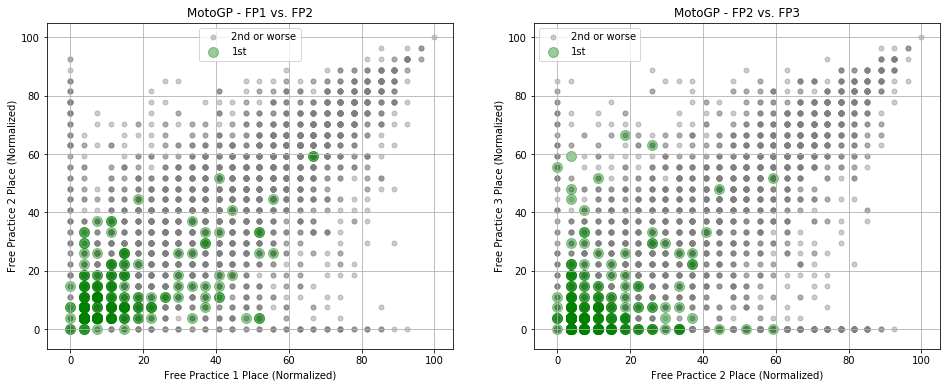

In [13]:
plt.clf()

fig = plt.figure(figsize=(16, 6))

cluster_labels = np.array(df_motogplabel['rresultWin'].values)

#df_motogpfeatures = df_motogpkbestnoidstdscaledfeatures
df_motogpfeatures = df_motogpkbestnoidmmscaledfeatures


# ---------

scatter_x = np.array(df_motogpfeatures['qresultPlaceFP1'].values)
scatter_y = np.array(df_motogpfeatures['qresultPlaceFP2'].values)

dict_label = {0: '2nd or worse', 1: '1st'}
dict_colors = {0: 'grey', 1: 'green'}
dict_size = {0: 100, 1: 400}

ax = fig.add_subplot(1, 2, 1)

for c in np.unique(cluster_labels):
    ix = np.where(cluster_labels == c)
    ax.scatter(scatter_x[ix], scatter_y[ix], 
               marker='.', s=dict_size[c], alpha=0.4, c=dict_colors[c], label=dict_label[c])

ax.set_title('MotoGP - FP1 vs. FP2')
ax.set_xlabel('Free Practice 1 Place (Normalized)')
ax.set_ylabel('Free Practice 2 Place (Normalized)')

ax.grid(True)

ax.legend()


# ---------

scatter_x = np.array(df_motogpfeatures['qresultPlaceFP2'].values)
scatter_y = np.array(df_motogpfeatures['qresultPlaceFP3'].values)

dict_label = {0: '2nd or worse', 1: '1st'}
dict_colors = {0: 'grey', 1: 'green'}
dict_size = {0: 100, 1: 400}

ax = fig.add_subplot(1, 2, 2)

for c in np.unique(cluster_labels):
    ix = np.where(cluster_labels == c)
    ax.scatter(scatter_x[ix], scatter_y[ix], 
               marker='.', s=dict_size[c], alpha=0.4, c=dict_colors[c], label=dict_label[c])

ax.set_title('MotoGP - FP2 vs. FP3')
ax.set_xlabel('Free Practice 2 Place (Normalized)')
ax.set_ylabel('Free Practice 3 Place (Normalized)')

ax.grid(True)

ax.legend()

plt.show()

In [14]:
fig.savefig('images/raw_winnerscatterplot.png', bbox_inches='tight', pad_inches=0.2)

<Figure size 432x288 with 0 Axes>

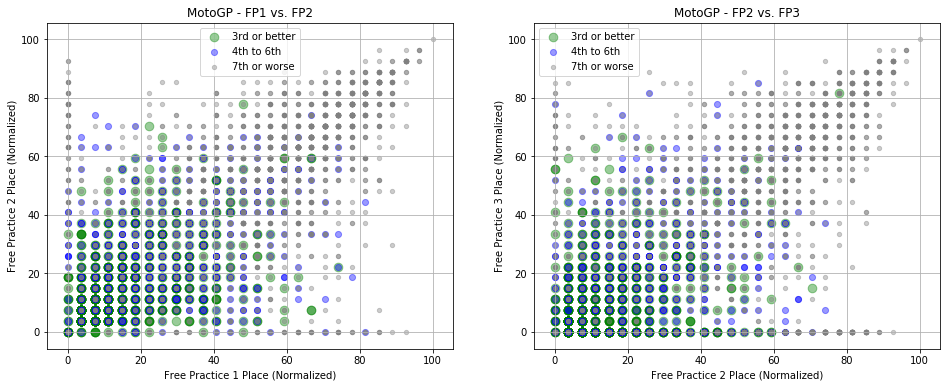

In [15]:
plt.clf()

fig = plt.figure(figsize=(16, 6))

cluster_labels = np.array(df_motogplabel['rresultPerformance'].values)

#df_motogpfeatures = df_motogpkbestnoidstdscaledfeatures
df_motogpfeatures = df_motogpkbestnoidmmscaledfeatures


# ---------

scatter_x = np.array(df_motogpfeatures['qresultPlaceFP1'].values)
scatter_y = np.array(df_motogpfeatures['qresultPlaceFP2'].values)

dict_label = {1: '3rd or better', 2: '4th to 6th', 3: '7th or worse'}
dict_colors = {1: 'green', 2: 'blue', 3: 'grey'}
dict_size = {1: 300, 2: 150, 3: 75}

ax = fig.add_subplot(1, 2, 1)

for c in np.unique(cluster_labels):
    ix = np.where(cluster_labels == c)
    ax.scatter(scatter_x[ix], scatter_y[ix], 
               marker='.', s=dict_size[c], alpha=0.4, c=dict_colors[c], label=dict_label[c])

ax.set_title('MotoGP - FP1 vs. FP2')
ax.set_xlabel('Free Practice 1 Place (Normalized)')
ax.set_ylabel('Free Practice 2 Place (Normalized)')

ax.grid(True)

ax.legend()


# ---------

scatter_x = np.array(df_motogpfeatures['qresultPlaceFP2'].values)
scatter_y = np.array(df_motogpfeatures['qresultPlaceFP3'].values)

dict_label = {1: '3rd or better', 2: '4th to 6th', 3: '7th or worse'}
dict_colors = {1: 'green', 2: 'blue', 3: 'grey'}
dict_size = {1: 300, 2: 150, 3: 75}

ax = fig.add_subplot(1, 2, 2)

for c in np.unique(cluster_labels):
    ix = np.where(cluster_labels == c)
    ax.scatter(scatter_x[ix], scatter_y[ix], 
               marker='.', s=dict_size[c], alpha=0.4, c=dict_colors[c], label=dict_label[c])

ax.set_title('MotoGP - FP2 vs. FP3')
ax.set_xlabel('Free Practice 2 Place (Normalized)')
ax.set_ylabel('Free Practice 3 Place (Normalized)')

ax.grid(True)

ax.legend()

plt.show()

In [16]:
fig.savefig('images/raw_performancescatterplot.png', bbox_inches='tight', pad_inches=0.2)

Create some helper functions for clustering techniques

In [17]:
from sklearn.utils import check_X_y
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.cluster.unsupervised import check_number_of_labels

from numba import jit

#@jit(nogil=True, parallel=True)
def euclidean_distances_numba(X, Y=None, Y_norm_squared=None):
    # disable checks
    XX_ = (X * X).sum(axis=1)
    XX = XX_.reshape((1, -1))

    if X is Y:  # shortcut in the common case euclidean_distances(X, X)
        YY = XX.T
    elif Y_norm_squared is not None:
        YY = Y_norm_squared
    else:
        YY_ = np.sum(Y * Y, axis=1)
        YY = YY_.reshape((1,-1))

    distances = np.dot(X, Y.T)
    distances *= -2
    distances += XX
    distances += YY
    distances = np.maximum(distances, 0)

    return np.sqrt(distances)


#@jit(parallel=True)
def euclidean_distances_sum(X, Y=None):
    if Y is None:
        Y = X
    Y_norm_squared = (Y ** 2).sum(axis=1)
    sums = np.zeros((len(X)))
    for i in range(len(X)):
        base_row = X[i, :]
        sums[i] = euclidean_distances_numba(base_row.reshape(1, -1), Y, Y_norm_squared=Y_norm_squared).sum()

    return sums


#@jit(parallel=True)
def euclidean_distances_mean(X, Y=None):
    if Y is None:
        Y = X
    Y_norm_squared = (Y ** 2).sum(axis=1)
    means = np.zeros((len(X)))
    for i in range(len(X)):
        base_row = X[i, :]
        means[i] = euclidean_distances_numba(base_row.reshape(1, -1), Y, Y_norm_squared=Y_norm_squared).mean()

    return means


def silhouette_samples_memory_saving(X, labels, metric='euclidean', **kwds):
    X, labels = check_X_y(X, labels, accept_sparse=['csc', 'csr'])
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    check_number_of_labels(len(le.classes_), X.shape[0])

    unique_labels = le.classes_
    n_samples_per_label = np.bincount(labels, minlength=len(unique_labels))

    # For sample i, store the mean distance of the cluster to which
    # it belongs in intra_clust_dists[i]
    intra_clust_dists = np.zeros(X.shape[0], dtype=X.dtype)

    # For sample i, store the mean distance of the second closest
    # cluster in inter_clust_dists[i]
    inter_clust_dists = np.inf + intra_clust_dists

    for curr_label in range(len(unique_labels)):

        # Find inter_clust_dist for all samples belonging to the same label.
        mask = labels == curr_label

        # Leave out current sample.
        n_samples_curr_lab = n_samples_per_label[curr_label] - 1
        if n_samples_curr_lab != 0:
            intra_clust_dists[mask] = euclidean_distances_sum(X[mask, :]) / n_samples_curr_lab

        # Now iterate over all other labels, finding the mean
        # cluster distance that is closest to every sample.
        for other_label in range(len(unique_labels)):
            if other_label != curr_label:
                other_mask = labels == other_label
                other_distances = euclidean_distances_mean(X[mask, :], X[other_mask, :])
                inter_clust_dists[mask] = np.minimum(inter_clust_dists[mask], other_distances)

    sil_samples = inter_clust_dists - intra_clust_dists
    sil_samples /= np.maximum(intra_clust_dists, inter_clust_dists)
    
    # score 0 for clusters of size 1, according to the paper
    sil_samples[n_samples_per_label.take(labels) == 1] = 0
    return sil_samples

C:\Users\buswedg\Anaconda3\envs\Python37\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.cluster.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics.cluster. Anything that cannot be imported from sklearn.metrics.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


Assess clustering counts applied to raw data

<Figure size 432x288 with 0 Axes>

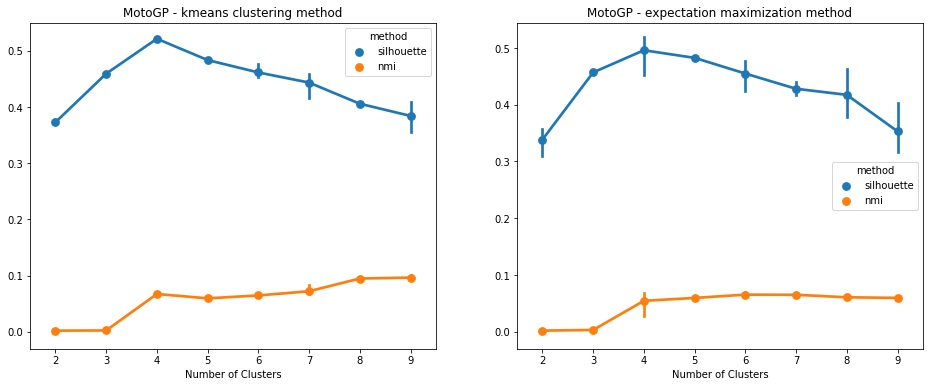

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score

from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score

np.random.seed(0)

plt.clf()

fig = plt.figure(figsize=(16, 6))

#df_motogpfeatures = df_motogpkbestnoidstdscaledfeatures
df_motogpfeatures = df_motogpkbestnoidmmscaledfeatures

range_n_clusters = range(2, 10)


# ---------

df_temp = pd.DataFrame(columns=['cluster_count', 'score', 'method'])

for n_clusters in range_n_clusters:
    for i in range(0, 5):
        clusterer = KMeans(n_clusters=n_clusters).fit(df_motogpfeatures)
        cluster_labels = clusterer.labels_

        silhouette_avg = silhouette_score(df_motogpfeatures, cluster_labels, sample_size=3000)
        nmi = normalized_mutual_info_score(df_motogplabel['rresultPerformance'].values, cluster_labels)
        
        df_temp.loc[len(df_temp.index)] = [n_clusters, silhouette_avg, 'silhouette']
        df_temp.loc[len(df_temp.index)] = [n_clusters, nmi, 'nmi']
    
ax = fig.add_subplot(1, 2, 1)

ax = sns.pointplot(x='cluster_count', y='score', hue='method', data=df_temp)

ax.set_title('MotoGP - kmeans clustering method')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('')


# ---------

df_temp = pd.DataFrame(columns=['cluster_count', 'score', 'method'])

for n_clusters in range_n_clusters:
    for i in range(0, 5):
        clusterer = GaussianMixture(n_components=n_clusters).fit(df_motogpfeatures)
        cluster_labels = clusterer.predict(df_motogpfeatures)

        silhouette_avg = silhouette_score(df_motogpfeatures, cluster_labels, sample_size=3000)
        nmi = normalized_mutual_info_score(df_motogplabel['rresultPerformance'].values, cluster_labels)

        df_temp.loc[len(df_temp.index)] = [n_clusters, silhouette_avg, 'silhouette']
        df_temp.loc[len(df_temp.index)] = [n_clusters, nmi, 'nmi']
    
ax = fig.add_subplot(1, 2, 2)

ax = sns.pointplot(x='cluster_count', y='score', hue='method', data=df_temp)

ax.set_title('MotoGP - expectation maximization method')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('')

plt.show()

In [19]:
fig.savefig('images/raw_clusterscore.png', bbox_inches='tight', pad_inches=0.2)

<Figure size 432x288 with 0 Axes>

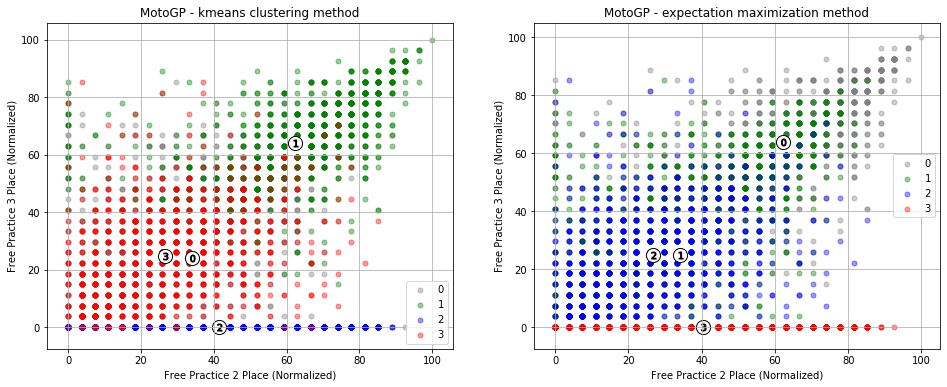

In [20]:
np.random.seed(0)

plt.clf()

fig = plt.figure(figsize=(16, 6))

#df_motogpfeatures = df_motogpkbestnoidstdscaledfeatures
df_motogpfeatures = df_motogpkbestnoidmmscaledfeatures


# ---------

clusterer = KMeans(n_clusters=4).fit(df_motogpfeatures)

cluster_labels = clusterer.labels_
       
scatter_x = np.array(df_motogpfeatures['qresultPlaceFP2'].values)
scatter_y = np.array(df_motogpfeatures['qresultPlaceFP3'].values)

dict_label = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4'}
dict_colors = {0: 'grey', 1: 'green', 2: 'blue', 3: 'red', 4: 'brown'}
dict_size = {0: 100, 1: 100, 2: 100, 3: 100, 4: 100}

ax = fig.add_subplot(1, 2, 1)

for c in np.unique(cluster_labels):
    ix = np.where(cluster_labels == c)
    ax.scatter(scatter_x[ix], scatter_y[ix], 
               marker='.', s=dict_size[c], alpha=0.4, c=dict_colors[c], label=dict_label[c])

cluster_centers = clusterer.cluster_centers_

ix_x = df_motogpfeatures.columns.get_loc('qresultPlaceFP2')
ix_y = df_motogpfeatures.columns.get_loc('qresultPlaceFP3')

ax.scatter(cluster_centers[:, ix_x], cluster_centers[:, ix_y], 
           marker='o', c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(cluster_centers):
    ax.scatter(c[ix_x], c[ix_y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    
ax.set_title('MotoGP - kmeans clustering method')
ax.set_xlabel('Free Practice 2 Place (Normalized)')
ax.set_ylabel('Free Practice 3 Place (Normalized)')

#ax.set_xlim(-5, 105)
#ax.set_ylim(-5, 105)

ax.grid(True)

ax.legend()


# ---------

clusterer = GaussianMixture(n_components=4).fit(df_motogpfeatures)
cluster_labels = clusterer.predict(df_motogpfeatures)
       
scatter_x = np.array(df_motogpfeatures['qresultPlaceFP2'].values)
scatter_y = np.array(df_motogpfeatures['qresultPlaceFP3'].values)

dict_label = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4'}
dict_colors = {0: 'grey', 1: 'green', 2: 'blue', 3: 'red', 4: 'brown'}
dict_size = {0: 100, 1: 100, 2: 100, 3: 100, 4: 100}

ax = fig.add_subplot(1, 2, 2)

for c in np.unique(cluster_labels):
    ix = np.where(cluster_labels == c)
    ax.scatter(scatter_x[ix], scatter_y[ix], 
               marker='.', s=dict_size[c], alpha=0.4, c=dict_colors[c], label=dict_label[c])

cluster_centers = clusterer.means_

ix_x = df_motogpfeatures.columns.get_loc('qresultPlaceFP2')
ix_y = df_motogpfeatures.columns.get_loc('qresultPlaceFP3')

ax.scatter(cluster_centers[:, ix_x], cluster_centers[:, ix_y], 
           marker='o', c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(cluster_centers):
    ax.scatter(c[ix_x], c[ix_y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    
ax.set_title('MotoGP - expectation maximization method')
ax.set_xlabel('Free Practice 2 Place (Normalized)')
ax.set_ylabel('Free Practice 3 Place (Normalized)')

ax.grid(True)

ax.legend()

plt.show()

In [21]:
fig.savefig('images/raw_clusterplot.png', bbox_inches='tight', pad_inches=0.2)

Time to apply some dimensionality reduction methods

In [22]:
def generate_varplot(df_data):
    """ """
    
    plt.clf()

    fig = plt.figure(figsize=(18, 4))
    
    df_data_std = df_data.std(axis=0)
    df_data_std = df_data_std.reset_index(level=0)
    df_data_std = np.round(df_data_std, 3)
        
    df_data_std.columns = ['Feature', 'Standard Deviation']
    df_data_std = df_data_std.sort_values(by='Standard Deviation', ascending=False)

    ax = sns.barplot(x='Feature', 
                     y='Standard Deviation', 
                     data=df_data_std, color='c')
    
    ax.set_xticklabels(ax.get_xticklabels(), 
                       rotation=45, ha='right')
    
    #ax.set_title('')
    ax.set_ylabel('Standard Deviation')

    return fig

<Figure size 432x288 with 0 Axes>

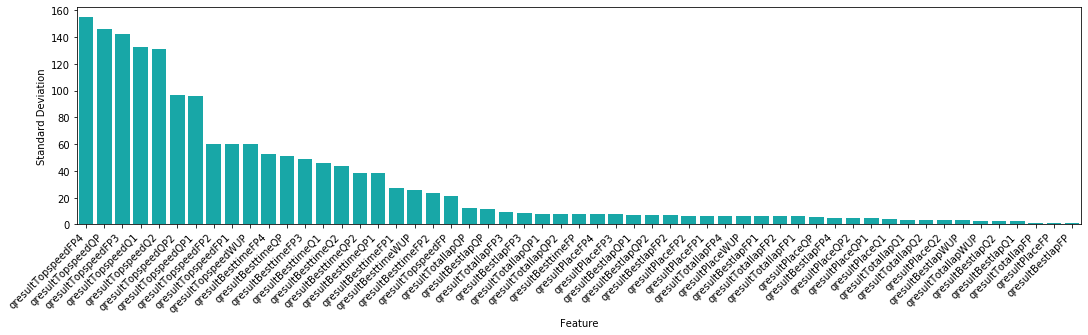

In [23]:
#df_data = df_motogpallnoidfeatures
df_data = df_motogpkbestnoidfeatures

fig = generate_varplot(df_data)

In [24]:
fig.savefig('images/motogp_varplot.png', bbox_inches='tight', pad_inches=0.2)

In [25]:
def generate_pca_expvarplot(df_motogpfeatures):
    
    from sklearn.decomposition import PCA
    
    np.random.seed(0)

    plt.clf()
    
    fig = plt.figure(figsize=(16, 6))

    pca_components = 6
   
    df_temp = pd.DataFrame(columns=['dimension', 'variance'])
    
    pca = PCA(n_components=pca_components)
    pca.fit(df_motogpfeatures)

    for c in range(0, pca_components):
        df_temp.loc[len(df_temp.index)] = [c+1, pca.explained_variance_ratio_[c]]
    
    df_temp = np.round(df_temp, 3)
    
    ax = fig.add_subplot(1, 1, 1)

    ax = sns.pointplot(x='dimension', y='variance', data=df_temp)

    ax.set_title('MotoGP - PCA explained variance plot')
    ax.set_xlabel('PCA Dimensions')
    ax.set_ylabel('Explained Variance')
    
    return fig

<Figure size 432x288 with 0 Axes>

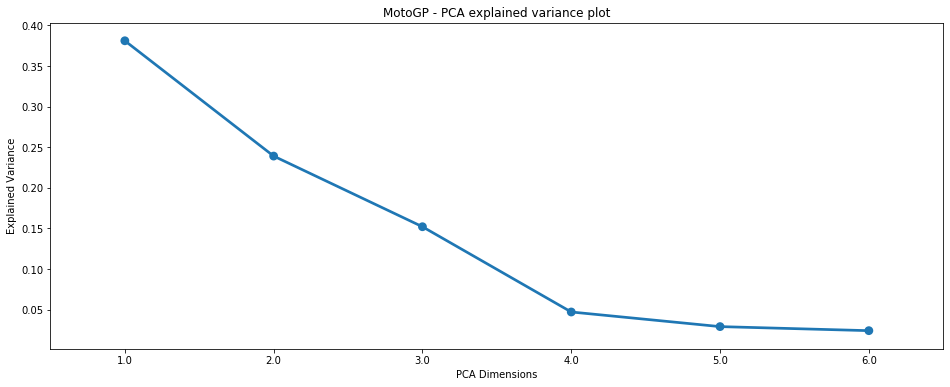

In [26]:
#df_motogpfeatures = df_motogpkbestnoidstdscaledfeatures
df_motogpfeatures = df_motogpkbestnoidmmscaledfeatures

fig = generate_pca_expvarplot(df_motogpfeatures)

In [27]:
fig.savefig('images/pca_expvarplot.png', bbox_inches='tight', pad_inches=0.2)

In [28]:
def generate_dimred_plotswlabel(df_motogpfeatures, df_motogplabel):
    ""
    
    from sklearn.decomposition import PCA
    from sklearn.decomposition import FastICA
    
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from mpl_toolkits.mplot3d import proj3d
    from matplotlib.patches import FancyArrowPatch
    get_ipython().run_line_magic('matplotlib', 'inline')
    
    class Arrow3D(FancyArrowPatch):
        def __init__(self, xs, ys, zs, *args, **kwargs):
            FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
            self._verts3d = xs, ys, zs

        def draw(self, renderer):
            xs3d, ys3d, zs3d = self._verts3d
            xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
            self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
            FancyArrowPatch.draw(self, renderer)
            
    
    np.random.seed(0)

    plt.clf()
    
    fig = plt.figure(figsize=(16, 6))
    
    # ---------

    pca = PCA(n_components=3, whiten=True).fit(df_motogpfeatures)

    df_reduced_data = pd.DataFrame(pca.transform(df_motogpfeatures), columns=['PC1', 'PC2', 'PC3'])

    scatter_x = np.array(df_reduced_data['PC1'].values)
    scatter_y = np.array(df_reduced_data['PC2'].values)
    scatter_z = np.array(df_reduced_data['PC3'].values)
    
    cluster_labels = np.array(df_motogplabel['rresultWin'].values)

    dict_label = {0: '2nd or worse', 1: '1st'}
    dict_colors = {0: 'grey', 1: 'green'}
    dict_size = {0: 10, 1: 40}

    ax = fig.add_subplot(1, 2, 1, projection='3d')

    for c in np.unique(cluster_labels):
        ix = np.where(cluster_labels == c)
        ax.scatter(scatter_x[ix], scatter_y[ix], scatter_z[ix],
                   marker='.', s=dict_size[c], alpha=0.7, c=dict_colors[c], label=dict_label[c])

    ls_motogphighleveragefeat = ['qresultTopspeedQP',
                                 'qresultTopspeedQ1',
                                 'qresultTopspeedFP3',
                                 'qresultTopspeedFP4']
    
    for i, (pc1, pc2, pc3) in enumerate(zip(pca.components_[0], pca.components_[1], pca.components_[2])):
        arw = Arrow3D([0, pc1],[0, pc2],[0, pc3], 
                      arrowstyle="-", color="orange", lw=1, mutation_scale=25)
        
        ax.add_artist(arw)

        if df_motogpfeatures.columns[i] in ls_motogphighleveragefeat: 
            if pc1 >= 0:
                ax.text(pc1, pc2, pc3, df_motogpfeatures.columns[i], ha='left')
                #ax.annotate(df_motogpfeatures.columns[i], (pc1, pc2, pc3), size=12, ha='left')

            else: 
                ax.text(pc1, pc2, pc3, df_motogpfeatures.columns[i], ha='right')
                #ax.annotate(df_motogpfeatures.columns[i], (pc1, pc2, pc3), size=12, ha='right')

    ax.set_title('MotoGP - PCA dimensions plot')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    
    ax.grid(True)

    ax.legend()
    
    
    # ---------

    ica = FastICA(n_components=3).fit(df_motogpfeatures)

    df_reduced_data = pd.DataFrame(ica.transform(df_motogpfeatures), columns=['ICA1', 'ICA2', 'ICA3'])

    scatter_x = np.array(df_reduced_data['ICA1'].values)
    scatter_y = np.array(df_reduced_data['ICA2'].values)
    scatter_z = np.array(df_reduced_data['ICA3'].values)
    
    cluster_labels = np.array(df_motogplabel['rresultWin'].values)

    dict_label = {0: '2nd or worse', 1: '1st'}
    dict_colors = {0: 'grey', 1: 'green'}
    dict_size = {0: 10, 1: 40}

    ax = fig.add_subplot(1, 2, 2, projection='3d')

    for c in np.unique(cluster_labels):
        ix = np.where(cluster_labels == c)
        ax.scatter(scatter_x[ix], scatter_y[ix], scatter_z[ix],
                   marker='.', s=dict_size[c], alpha=0.7, c=dict_colors[c], label=dict_label[c])

    ax.set_title('MotoGP - ICA dimensions plot')
    ax.set_xlabel('ICA1')
    ax.set_ylabel('ICA2')
    ax.set_zlabel('ICA3')
    
    ax.grid(True)

    ax.legend()
    
    return fig

<Figure size 432x288 with 0 Axes>

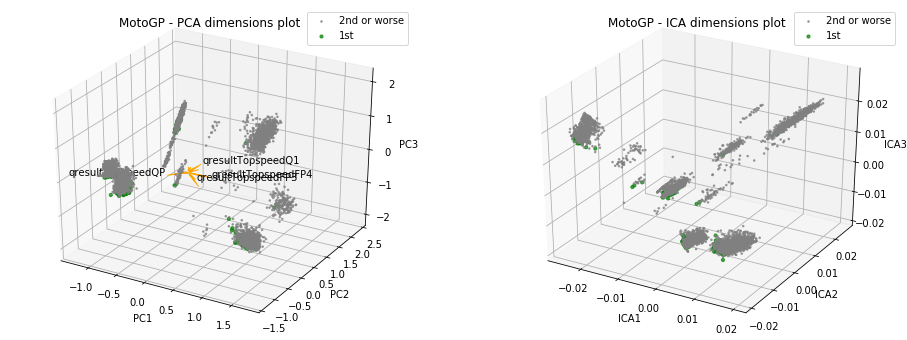

In [29]:
#df_motogpfeatures = df_motogpkbestnoidstdscaledfeatures
df_motogpfeatures = df_motogpkbestnoidmmscaledfeatures

fig = generate_dimred_plotswlabel(df_motogpfeatures, df_motogplabel)

In [30]:
fig.savefig('images/dimred_plotswlabel.png', bbox_inches='tight', pad_inches=0.2)

Now, let's re-apply our clustering techniques to the reduced dataset

<Figure size 432x288 with 0 Axes>

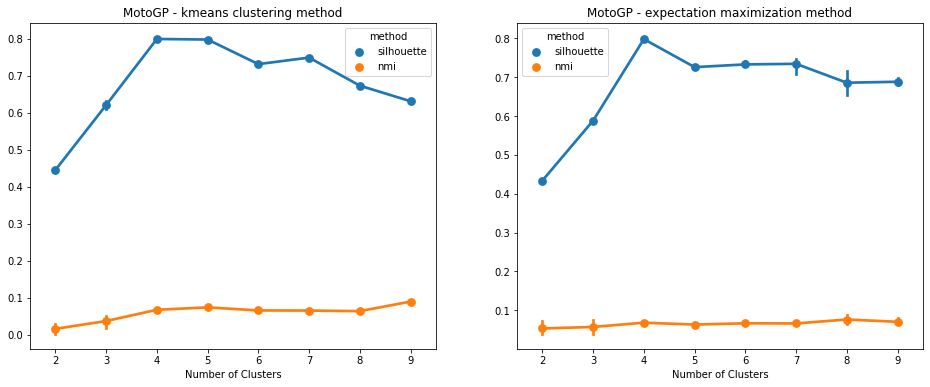

In [32]:
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score

from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score

np.random.seed(0)

plt.clf()

fig = plt.figure(figsize=(16, 6))

#df_motogpfeatures = df_motogpkbestnoidstdscaledfeatures
df_motogpfeatures = df_motogpkbestnoidmmscaledfeatures

range_n_clusters = range(2, 10)


# ---------

pca = PCA(n_components=3, whiten=True).fit(df_motogpfeatures)

df_reduced_data = pd.DataFrame(pca.transform(df_motogpfeatures), columns=['PC1', 'PC2', 'PC3'])

df_temp = pd.DataFrame(columns=['cluster_count', 'score', 'method'])

for n_clusters in range_n_clusters:
    for i in range(0, 5):
        clusterer = KMeans(n_clusters=n_clusters).fit(df_reduced_data)
        cluster_labels = clusterer.labels_

        silhouette_avg = silhouette_score(df_reduced_data, cluster_labels, sample_size=3000)
        nmi = normalized_mutual_info_score(df_motogplabel['rresultPerformance'].values, cluster_labels)
        
        df_temp.loc[len(df_temp.index)] = [n_clusters, silhouette_avg, 'silhouette']
        df_temp.loc[len(df_temp.index)] = [n_clusters, nmi, 'nmi']
    
ax = fig.add_subplot(1, 2, 1)

ax = sns.pointplot(x='cluster_count', y='score', hue='method', data=df_temp)

ax.set_title('MotoGP - kmeans clustering method')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('')


# ---------

ica = FastICA(n_components=3).fit(df_motogpfeatures)

df_reduced_data = pd.DataFrame(ica.transform(df_motogpfeatures), columns=['ICA1', 'ICA2', 'ICA3'])

df_temp = pd.DataFrame(columns=['cluster_count', 'score', 'method'])

for n_clusters in range_n_clusters:
    for i in range(0, 5):
        clusterer = GaussianMixture(n_components=n_clusters).fit(df_reduced_data)
        cluster_labels = clusterer.predict(df_reduced_data)

        silhouette_avg = silhouette_score(df_reduced_data, cluster_labels, sample_size=3000)
        nmi = normalized_mutual_info_score(df_motogplabel['rresultPerformance'].values, cluster_labels)

        df_temp.loc[len(df_temp.index)] = [n_clusters, silhouette_avg, 'silhouette']
        df_temp.loc[len(df_temp.index)] = [n_clusters, nmi, 'nmi']
    
ax = fig.add_subplot(1, 2, 2)

ax = sns.pointplot(x='cluster_count', y='score', hue='method', data=df_temp)

ax.set_title('MotoGP - expectation maximization method')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('')

plt.show()

In [33]:
def generate_dimred_plotswcluster(df_motogpfeatures, df_motogplabel):
    ""
    
    from sklearn.decomposition import PCA
    from sklearn.decomposition import FastICA
    
    from sklearn.cluster import KMeans
    
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from mpl_toolkits.mplot3d import proj3d
    from matplotlib.patches import FancyArrowPatch
    get_ipython().run_line_magic('matplotlib', 'inline')
    
    class Arrow3D(FancyArrowPatch):
        def __init__(self, xs, ys, zs, *args, **kwargs):
            FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
            self._verts3d = xs, ys, zs

        def draw(self, renderer):
            xs3d, ys3d, zs3d = self._verts3d
            xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
            self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
            FancyArrowPatch.draw(self, renderer)
            
    
    np.random.seed(0)

    plt.clf()
    
    fig = plt.figure(figsize=(16, 6))
    
    # ---------

    pca = PCA(n_components=3, whiten=True).fit(df_motogpfeatures)

    df_reduced_data = pd.DataFrame(pca.transform(df_motogpfeatures), columns=['PC1', 'PC2', 'PC3'])

    clusterer = KMeans(n_clusters=4).fit(df_reduced_data)
    cluster_labels = clusterer.labels_

    scatter_x = np.array(df_reduced_data['PC1'].values)
    scatter_y = np.array(df_reduced_data['PC2'].values)
    scatter_z = np.array(df_reduced_data['PC3'].values)

    dict_label = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4'}
    dict_colors = {0: 'grey', 1: 'green', 2: 'blue', 3: 'red', 4: 'brown'}
    dict_size = {0: 10, 1: 10, 2: 10, 3: 10, 4: 10}

    ax = fig.add_subplot(1, 2, 1, projection='3d')

    for c in np.unique(cluster_labels):
        ix = np.where(cluster_labels == c)
        ax.scatter(scatter_x[ix], scatter_y[ix], scatter_z[ix],
                   marker='.', s=dict_size[c], alpha=0.7, c=dict_colors[c], label=dict_label[c])

    #cluster_centers = clusterer.cluster_centers_

    #ix_x = df_reduced_data.columns.get_loc('PC1')
    #ix_y = df_reduced_data.columns.get_loc('PC2')
    #ix_z = df_reduced_data.columns.get_loc('PC3')

    #ax.scatter(cluster_centers[:, ix_x], cluster_centers[:, ix_y], cluster_centers[:, ix_z],
    #           marker='o', c="white", alpha=1, s=200, edgecolor='k')

    #for i, c in enumerate(cluster_centers):
    #    ax.scatter(c[ix_x], c[ix_y], c[ix_z], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
        
    ls_motogphighleveragefeat = ['qresultTopspeedQP',
                                 'qresultTopspeedQ1',
                                 'qresultTopspeedFP3',
                                 'qresultTopspeedFP4']
    
    for i, (pc1, pc2, pc3) in enumerate(zip(pca.components_[0], pca.components_[1], pca.components_[2])):
        arw = Arrow3D([0, pc1],[0, pc2],[0, pc3], 
                      arrowstyle="-", color="orange", lw=1, mutation_scale=25)
        
        ax.add_artist(arw)

        if df_motogpfeatures.columns[i] in ls_motogphighleveragefeat: 
            if pc1 >= 0:
                ax.text(pc1, pc2, pc3, df_motogpfeatures.columns[i], ha='left')
                #ax.annotate(df_motogpfeatures.columns[i], (pc1, pc2, pc3), size=12, ha='left')

            else: 
                ax.text(pc1, pc2, pc3, df_motogpfeatures.columns[i], ha='right')
                #ax.annotate(df_motogpfeatures.columns[i], (pc1, pc2, pc3), size=12, ha='right')

    ax.set_title('MotoGP - PCA dimensions plot')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    
    ax.grid(True)

    ax.legend()    
    
    
    # ---------

    ica = FastICA(n_components=3).fit(df_motogpfeatures)

    df_reduced_data = pd.DataFrame(ica.transform(df_motogpfeatures), columns=['ICA1', 'ICA2', 'ICA3'])

    clusterer = KMeans(n_clusters=4).fit(df_reduced_data)
    cluster_labels = clusterer.labels_

    scatter_x = np.array(df_reduced_data['ICA1'].values)
    scatter_y = np.array(df_reduced_data['ICA2'].values)
    scatter_z = np.array(df_reduced_data['ICA3'].values)

    dict_label = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4'}
    dict_colors = {0: 'grey', 1: 'green', 2: 'blue', 3: 'red', 4: 'brown'}
    dict_size = {0: 10, 1: 10, 2: 10, 3: 10, 4: 10}

    ax = fig.add_subplot(1, 2, 2, projection='3d')

    for c in np.unique(cluster_labels):
        ix = np.where(cluster_labels == c)
        ax.scatter(scatter_x[ix], scatter_y[ix], scatter_z[ix],
                   marker='.', s=dict_size[c], alpha=0.7, c=dict_colors[c], label=dict_label[c])

    #cluster_centers = clusterer.cluster_centers_

    #ix_x = df_reduced_data.columns.get_loc('ICA1')
    #ix_y = df_reduced_data.columns.get_loc('ICA2')
    #ix_z = df_reduced_data.columns.get_loc('ICA3')

    #ax.scatter(cluster_centers[:, ix_x], cluster_centers[:, ix_y], cluster_centers[:, ix_z],
    #           marker='o', c="white", alpha=1, s=200, edgecolor='k')

    #for i, c in enumerate(cluster_centers):
    #    ax.scatter(c[ix_x], c[ix_y], c[ix_z], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax.set_title('MotoGP - ICA dimensions plot')
    ax.set_xlabel('ICA1')
    ax.set_ylabel('ICA2')
    ax.set_zlabel('ICA3')
    
    ax.grid(True)

    ax.legend()
    
    return fig

<Figure size 432x288 with 0 Axes>

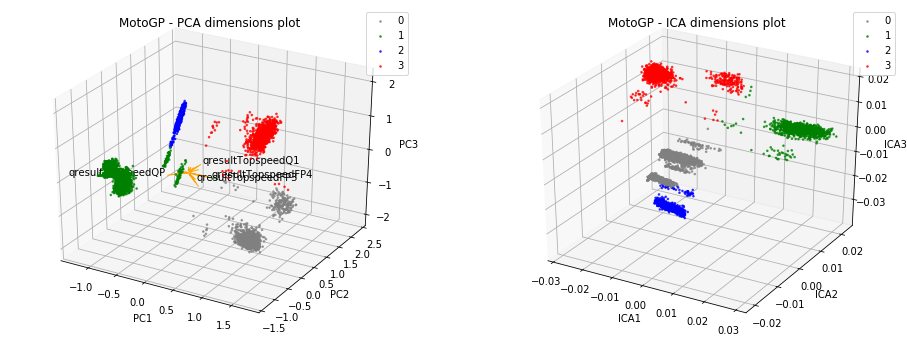

In [34]:
#df_motogpfeatures = df_motogpkbestnoidstdscaledfeatures
df_motogpfeatures = df_motogpkbestnoidmmscaledfeatures

fig = generate_dimred_plotswcluster(df_motogpfeatures, df_motogplabel)

In [35]:
fig.savefig('images/dimred_plotswcluster.png', bbox_inches='tight', pad_inches=0.2)

What do the cluster centoids look like for our highly leveraging features?

In [36]:
from sklearn.decomposition import PCA

#df_motogpfeatures = df_motogpkbestnoidstdscaledfeatures
df_motogpfeatures = df_motogpkbestnoidmmscaledfeatures

pca = PCA(n_components=2, whiten=True).fit(df_motogpfeatures)

df_reduced_data = pd.DataFrame(pca.transform(df_motogpfeatures), columns=['PCA1', 'PCA2'])

clusterer = KMeans(n_clusters=3).fit(df_reduced_data)

cluster_centers = clusterer.cluster_centers_

ls_motogphighleveragefeat = ['qresultTopspeedQP',
                             'qresultTopspeedQ1',
                             'qresultTopspeedFP3',
                             'qresultTopspeedFP4']

df_converted_centoids = pd.DataFrame(pca.inverse_transform(cluster_centers), columns=df_motogpfeatures.columns)
df_converted_centoids = np.round(df_converted_centoids, 3)

df_converted_centoids = df_converted_centoids[ls_motogphighleveragefeat]

df_converted_centoids

,qresultTopspeedQP,qresultTopspeedQ1,qresultTopspeedFP3,qresultTopspeedFP4
0,-0.157,51.431,89.596,86.225
1,81.494,-1.508,55.948,0.983
2,-1.299,-0.105,-10.207,2.168


In [37]:
from sklearn.decomposition import FastICA

#df_motogpfeatures = df_motogpkbestnoidstdscaledfeatures
df_motogpfeatures = df_motogpkbestnoidmmscaledfeatures

ica = FastICA(n_components=2).fit(df_motogpfeatures)

df_reduced_data = pd.DataFrame(ica.transform(df_motogpfeatures), columns=['ICA1', 'ICA2'])

clusterer = KMeans(n_clusters=4).fit(df_reduced_data)

cluster_centers = clusterer.cluster_centers_

ls_motogphighleveragefeat = ['qresultTopspeedQP',
                             'qresultTopspeedQ1',
                             'qresultTopspeedFP3',
                             'qresultTopspeedFP4']

df_converted_centoids = pd.DataFrame(ica.inverse_transform(cluster_centers), columns=df_motogpfeatures.columns)
df_converted_centoids = np.round(df_converted_centoids, 3)

df_converted_centoids = df_converted_centoids[ls_motogphighleveragefeat]

df_converted_centoids[0:3]

,qresultTopspeedQP,qresultTopspeedQ1,qresultTopspeedFP3,qresultTopspeedFP4
0,-0.168,51.447,89.617,86.250
1,85.733,1.055,64.390,5.220
2,-1.299,-0.105,-10.207,2.168
